In [1]:
import numpy as np ##importing libraries
import os
import matplotlib.pyplot as plt
import cv2
from tqdm.auto import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.nn import Linear, ReLU, MSELoss, L1Loss, Sequential, Conv2d, ConvTranspose2d, MaxPool2d, AdaptiveAvgPool2d, Module,BatchNorm2d, Sigmoid, Dropout
from torchvision.utils import make_grid

In [2]:
# from torch.nn.parameter import Parameter
# import torch.nn.functional as F  


# class Sim(torch.nn.Module):
#     def __init__(self, channels = None, e_lambda = 1e-4):
#         super(Sim, self).__init__()

#         self.activaton = nn.Sigmoid()
#         self.e_lambda = e_lambda

#     def __repr__(self):
#         s = self.__class__.__name__ + '('
#         s += ('lambda=%f)' % self.e_lambda)
#         return s

#     @staticmethod
#     def get_module_name():
#         return "simam"

#     def forward(self, x):

#         b, c, h, w = x.size()
       
#         n = w * h - 1

#         x_minus_mu_square = (x - x.mean(dim=[2,3], keepdim=True)).pow(2)
#         y = x_minus_mu_square / (4 * (x_minus_mu_square.sum(dim=[2,3], keepdim=True) / n + self.e_lambda)) + 0.5

#         return x*self.activaton(y)
# class L2(nn.Module):
#     def __init__(self, dim=1, eps=1e-12):
#         super(L2, self).__init__()
#         self.dim = dim
#         self.eps = eps

#     def forward(self, x):
#         return F.normalize(x, p=2, dim=self.dim, eps=self.eps)
# import math
# class Sim_ab(torch.nn.Module):
#     def __init__(self, channel,gamma=2, b=1):
#         super(Sim_ab,self).__init__()
#         self.sim=Sim()
#        # self.cfc=Parameter(torch.Tensor(channel))
#         #self.cfc.data.fill_(0)
#         t = int(abs((math.log(channel, 2) + b) / gamma))
#         k = t if t % 2 else t + 1
#         self.conv = nn.Conv1d(1, 1, kernel_size=k, padding=(k - 1) // 2, bias=False)
#         self.sigmoid = nn.Sigmoid()
#         self.L2=L2()
       
#     def forward(self, x):
#         b,c,h,w=x.shape
#         x1=self.sim(x)
#         x1=self.L2(x1)
#         x2=torch.mean(x, dim=(2,3), keepdim=True)
#        # avg_x1=x_1*self.cfc[None,:,None,None]
#         x2= self.conv(x2.squeeze(-1).transpose(-1, -2)).transpose(-1, -2).unsqueeze(-1)
#         x2=self.sigmoid(x2)
#         x2=self.L2(x2)

#         return x1+x2
    

In [3]:
##unet model: baseline model
class conv_block(nn.Module):
    def __init__(self, in_c, out_c):

        super().__init__()

        self.conv1=nn.Conv2d(in_c, out_c, kernel_size=3, padding=1)
        # self.SIM1=Sim_ab(out_c)

        self.bn1=nn.BatchNorm2d(out_c)
        self.conv2=nn.Conv2d(out_c, out_c, kernel_size=3, padding=1)
        # self.SIM2=Sim_ab(out_c)

        self.bn2=nn.BatchNorm2d(out_c)
        self.relu=nn.ReLU()



    def forward(self, inputs):
        x=self.conv1(inputs)
        ##attention
        # x=self.SIM1(x)
        x=self.bn1(x)
        x=self.relu(x)
        x=self.conv2(x)
        ##attention
        # x=self.SIM2(x)
        x=self.bn2(x)
        x=self.relu(x)
        return x

class encoder_block(nn.Module):
    def __init__(self, in_c, out_c):

        super().__init__()
        self.conv=conv_block(in_c,out_c)
        self.dropout=nn.Dropout(0.25)###dropout layer?? use it ;
        self.pool=nn.MaxPool2d((2,2))

    def forward(self, inputs):
        x=self.conv(inputs)
        x=self.dropout(x)##dropout??
        p=self.pool(x)
        return x, p

class decoder_block(nn.Module):
    def __init__(self, in_c, out_c):


        super().__init__()
        self.up=nn.ConvTranspose2d(in_c, out_c,kernel_size=2, stride=2, padding=0)
        # self.SIM=Sim_ab(out_c)
        self.conv=conv_block(out_c+out_c, out_c)
        
    def forward(self, inputs, skip):
        x=self.up(inputs)
        # skip=self.SIM(skip)###attention??
        x=torch.cat([x,skip], axis=1)
        x=self.conv(x)
        return x

class build_base(nn.Module):
    def __init__(self):
        super().__init__()

        ##encoder block
        self.e1=encoder_block(1,32)##3channels?/
        self.e2=encoder_block(32,64)
        self.e3=encoder_block(64,128)
        self.e4=encoder_block(128,256)
        self.b=conv_block(256,512)
        self.d1=decoder_block(512,256)
        self.d2=decoder_block(256,128)
        self.d3=decoder_block(128,64)
        self.d4=decoder_block(64,32)
        self.outputs=nn.Conv2d(32,1,kernel_size=1,padding=0)

    def forward(self, inputs):
        s1,p1=self.e1(inputs)
        s2,p2=self.e2(p1)
        s3,p3=self.e3(p2)
        s4,p4=self.e4(p3)
        b=self.b(p4)
        d1=self.d1(b,s4)
        d2=self.d2(d1,s3)
        d3=self.d3(d2,s2)
        d4=self.d4(d3,s1)
        outputs=self.outputs(d4)
        return outputs


In [4]:
torch.set_flush_denormal(True)

True

In [5]:
##training script
##importing libraries
import random
import time

In [6]:
np.random.seed(42)
torch.manual_seed(42)

In [7]:
path='C:/Users/ah_wo/Attention_experiments/single_coil_train_val/'

pth_noisy = 0.png
path_clean= C:/Users/ah_wo/Attention_experiments/single_coil_train_val/train_lax_renamed_ALL/target_FS/0.png
pth_noisy = 1.png
path_clean= C:/Users/ah_wo/Attention_experiments/single_coil_train_val/train_lax_renamed_ALL/target_FS/1.png
pth_noisy = 10.png
path_clean= C:/Users/ah_wo/Attention_experiments/single_coil_train_val/train_lax_renamed_ALL/target_FS/10.png
pth_noisy = 100.png
path_clean= C:/Users/ah_wo/Attention_experiments/single_coil_train_val/train_lax_renamed_ALL/target_FS/100.png
pth_noisy = 101.png
path_clean= C:/Users/ah_wo/Attention_experiments/single_coil_train_val/train_lax_renamed_ALL/target_FS/101.png
pth_noisy = 102.png
path_clean= C:/Users/ah_wo/Attention_experiments/single_coil_train_val/train_lax_renamed_ALL/target_FS/102.png
pth_noisy = 103.png
path_clean= C:/Users/ah_wo/Attention_experiments/single_coil_train_val/train_lax_renamed_ALL/target_FS/103.png
pth_noisy = 104.png
path_clean= C:/Users/ah_wo/Attention_experiments/single_coil_train_val/tr

c:\Users\ah_wo\anaconda3\Lib\site-packages\numpy\core\getlimits.py:518: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
c:\Users\ah_wo\anaconda3\Lib\site-packages\numpy\core\getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


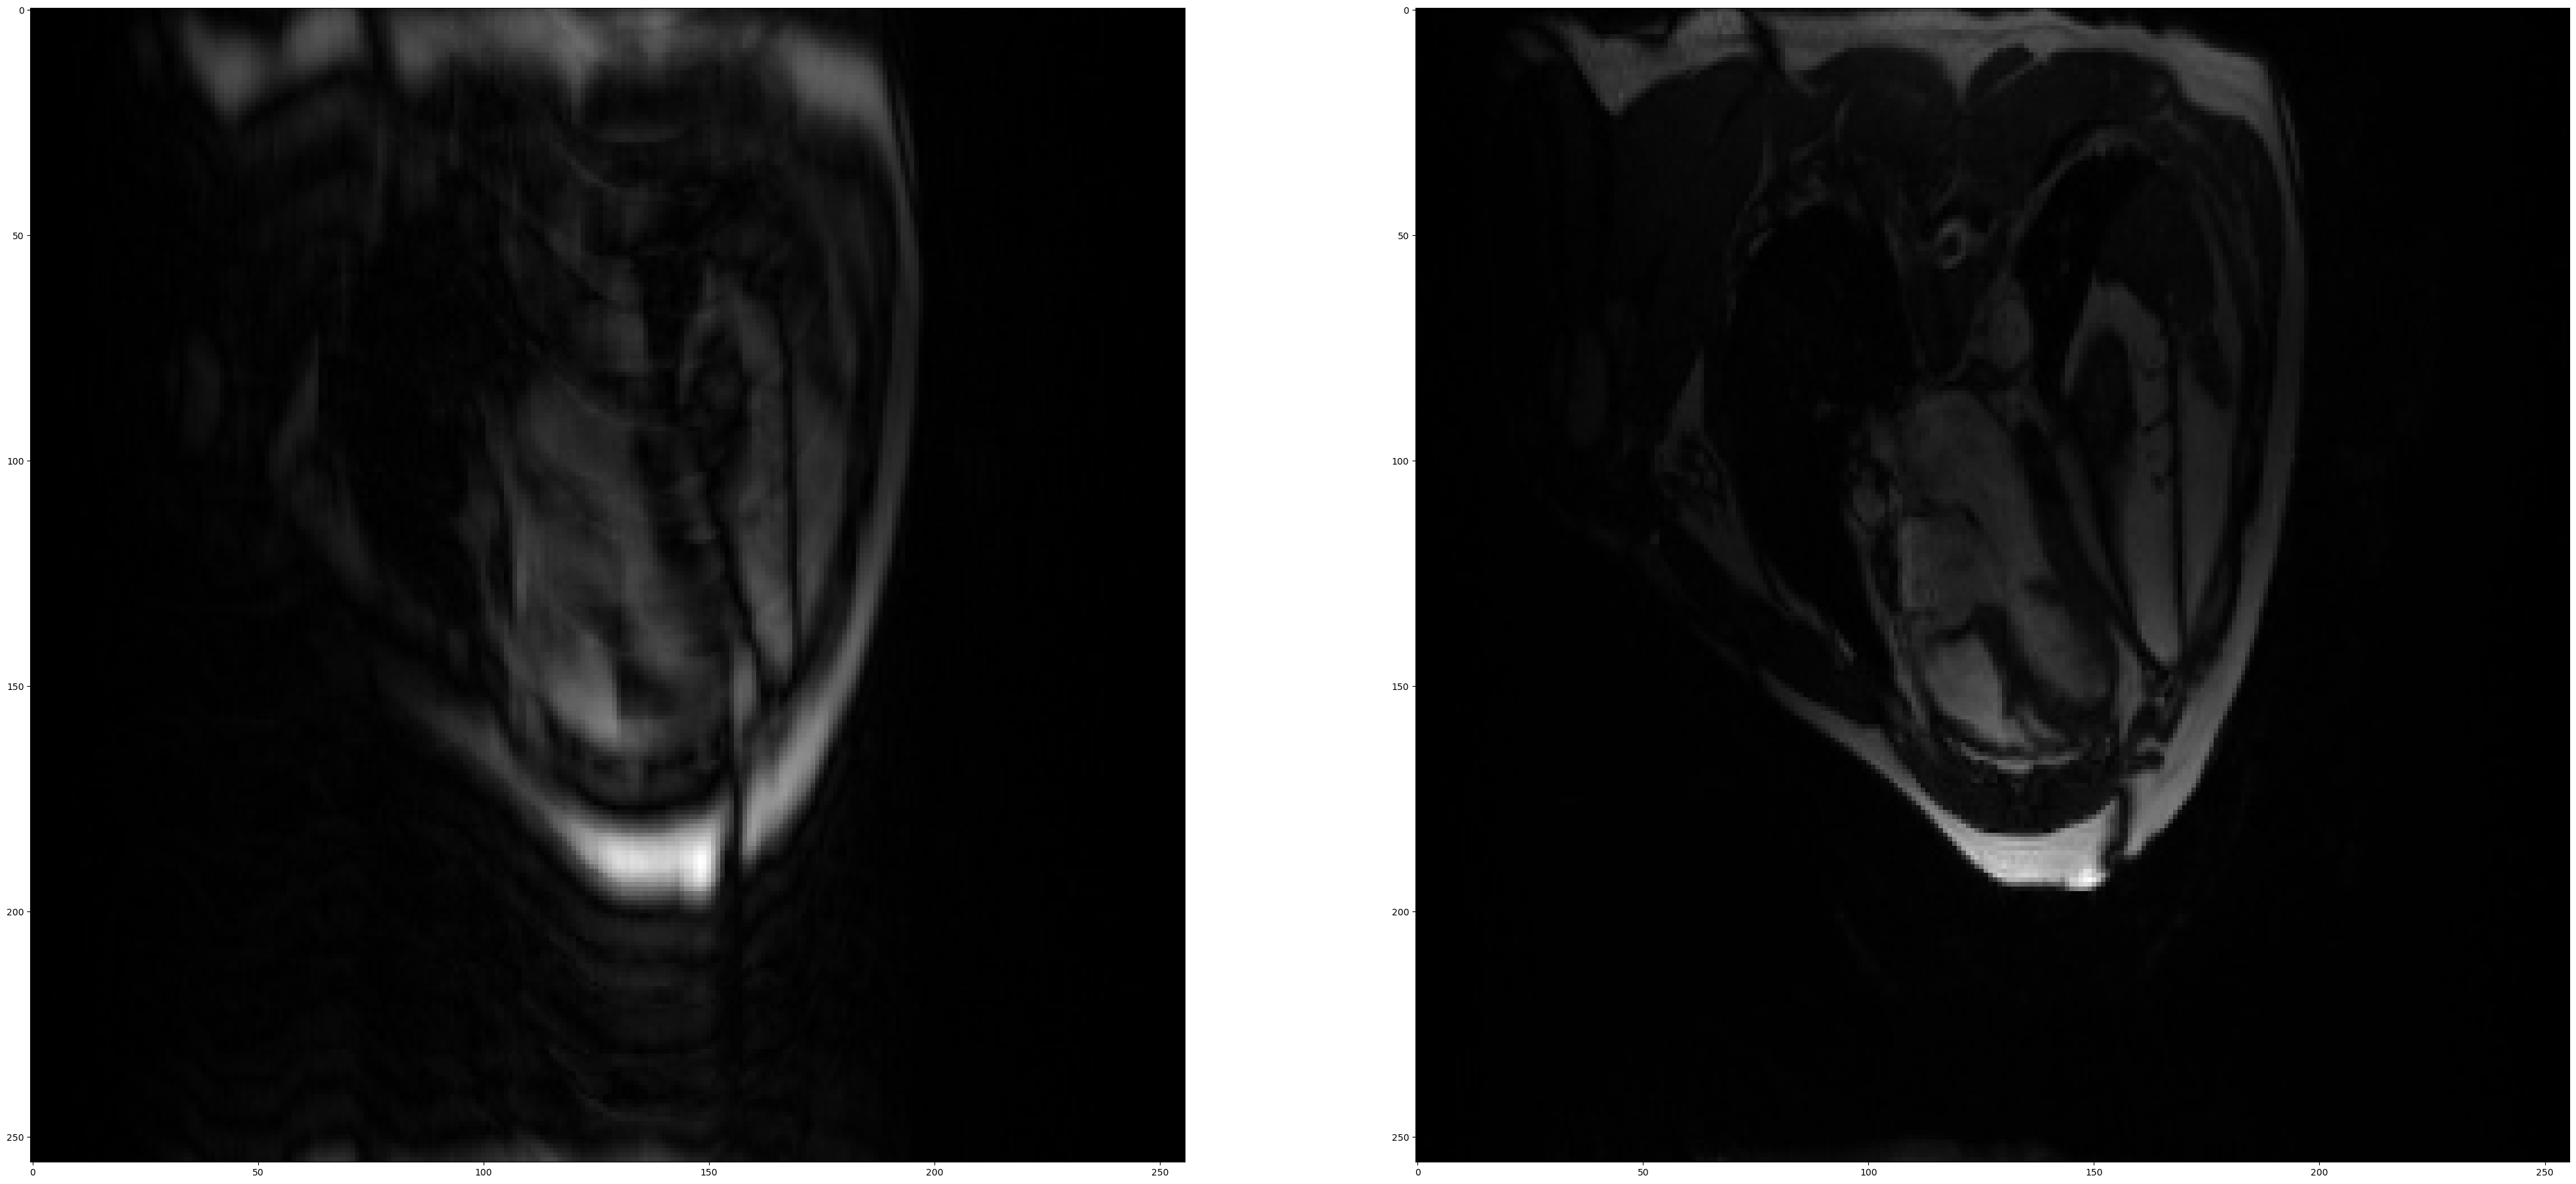

In [8]:
##data loader class
class DataLoader_Class:
    def __init__(self, path):
        self.path=path
        self.train_images=[]
        self.train_cleaned=[]
        self.test_images=[]
        self.test_cleaned=[]

    def read_all_images(self):
        self.train_images_path=[(self.path  + 'train_lax_renamed_ALL/input_AC/' + f)
                                   for f in sorted(os.listdir(self.path + 'train_lax_renamed_ALL/input_AC/'))]
        self.train_cleaned_path = [(self.path  + 'train_lax_renamed_ALL/target_FS/' + f)
                                   for f in sorted(os.listdir(self.path + 'train_lax_renamed_ALL/target_FS/'))]

        self.test_images_path  = [(self.path  + 'val_lax_renamed_ALL/input_AC/' + f)
                                   for f in sorted(os.listdir(self.path + 'val_lax_renamed_ALL/input_AC/'))]

        self.test_cleaned_path = [(self.path  + 'val_lax_renamed_ALL/target_FS/' + f)
                                   for f in sorted(os.listdir(self.path + 'val_lax_renamed_ALL/target_FS/'))]

        transform = transforms.Compose([
            transforms.ToTensor(),
            #rotation_transform(),
            #transforms.Normalize((0.5, ), (0.5, )),
        ])

        for path in self.train_images_path:
            pth_noisy=path.split('/')[-1]
            print('pth_noisy =',pth_noisy)
            fname=pth_noisy.split('.')[0]
            path_clean=path.replace('input_AC','target_FS')
            print('path_clean=',path_clean)

            img=cv2.imread(path)
            img=np.asarray(img, dtype="uint8")
            img=cv2.resize(img, (256,256))
            img=(img-np.min(img))/(np.max(img)-np.min(img))
            img=img[:,:,0]##1 channel only??


            img_cleaned=cv2.imread(path_clean)
            img_cleaned=np.asarray(img_cleaned,dtype="uint8")
            img_cleaned=cv2.resize(img_cleaned, (256,256))##256,256
            img_cleaned=(img_cleaned-np.min(img_cleaned))/(np.max(img_cleaned)-np.min(img_cleaned))
            img_cleaned=img_cleaned[:,:,0]

            img=transforms.ToTensor()(img.astype('float32'))
            clean_img=transforms.ToTensor()(img_cleaned.astype('float32'))

            ##no rotation transform

            self.train_images.append(img)
            self.train_cleaned.append(clean_img)

        for path in self.test_images_path:
            img=cv2.imread(path)
            print('test_images_path = ',path)
            img=np.asarray(img, dtype="uint8")
            img=cv2.resize(img, (256,256))
            img= (img-np.min(img))/(np.max(img)-np.min(img))
            img=img[:,:,0]
            img=transforms.ToTensor()(img.astype('float32'))

            self.test_images.append(img)

        for path in self.test_cleaned_path:
            img=cv2.imread(path)
            img=np.asarray(img, dtype="uint8")
            img=cv2.resize(img, (256,256))
            img=(img-np.min(img))/(np.max(img)-np.min(img))
            img=img[:,:,0]
            img=transforms.ToTensor()(img.astype('float32'))
            self.test_cleaned.append(img)


        ###convert to tensor
        self.train_images=torch.stack(self.train_images)
        self.train_cleaned=torch.stack(self.train_cleaned)
        self.test_images=torch.stack(self.test_images)
        self.test_cleaned=torch.stack(self.test_cleaned)

        print(self.train_images.shape)
        print(self.train_cleaned.shape)
        print(self.test_images.shape)
        print(self.test_cleaned.shape)

        return self.train_images, self.train_cleaned, self.test_images, self.test_cleaned

    def see_an_image(self, number):
        f, axarr=plt.subplots(1,2, figsize=(50,100))
        axarr[0].imshow(self.train_images[number].permute(1,2,0),cmap="gray")
        axarr[1].imshow(self.train_cleaned[number].permute(1,2,0),cmap="gray")

data_loader=DataLoader_Class(path)
train_set_x, train_set_y, test_set_x, test_set_y= data_loader.read_all_images()
data_loader.see_an_image(0)

In [9]:
batch_size=2
from torch.utils.data import Dataset

In [10]:
class Dataset_AE(Dataset):
    def __init__(self, X_train, y_train):
        self.X_train=X_train
        self.y_train=y_train
        
    def __len__(self):
        return len(self.y_train)
    
    def __getitem__(self, idx):
        return self.X_train[idx], self.y_train[idx]
    
training_set=Dataset_AE(train_set_x, train_set_y)
train_loader=torch.utils.data.DataLoader(training_set, batch_size=batch_size, shuffle=True)
test_set=Dataset_AE(test_set_x, test_set_y)
test_loader=torch.utils.data.DataLoader(test_set,batch_size=batch_size, shuffle=False)

In [11]:
np.shape(test_set_x)

torch.Size([200, 1, 256, 256])

In [12]:
##model definition
model=build_base()

In [13]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [14]:
from typing import Optional
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
EPS=1e-7
def PSNR(input, target):
    return -10*torch.log10(torch.mean((input - target) ** 2, dim=[1, 2, 3])+EPS)
def MSE(input, target):
    return torch.mean((input - target) ** 2, dim=[1, 2, 3])
def ssim(
    gt: np.ndarray, pred: np.ndarray, maxval: Optional[float] = None
) -> np.ndarray:
    """Compute Structural Similarity Index Metric (SSIM)"""
    if maxval is None:
        maxval = gt.max()
    return structural_similarity(gt, pred, data_range=maxval)



c:\Users\ah_wo\anaconda3\Lib\site-packages\numpy\core\getlimits.py:518: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
c:\Users\ah_wo\anaconda3\Lib\site-packages\numpy\core\getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


In [15]:
##saving path
save_path = 'C:/Users/ah_wo/Attention_experiments/New_results/Baseline/'

In [16]:
def train(model, num_epochs=5, batch_size=2, learning_rate=0.001):#was 0.001 and gave better results

    criterion = nn.MSELoss() # mean square error loss
    #criterion = MS_SSIM_L1_LOSS()

    optimizer = optim.AdamW(model.parameters(), lr=learning_rate)

    #scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma = 0.95)

    early_stopper = EarlyStopper(patience=3, min_delta=10)#was min_delta=10
    outputs = []
    loss_arr= []
    val_loss_arr=[]

    psnr = []
    mse = []
    SSIM_arr=[]

    psnr_all = []
    mse_all = []

    val_psnr = []
    val_mse = []
    val_SSIM_arr=[]

    val_psnr_all = []
    val_mse_all = []

    for epoch in tqdm(range(num_epochs)):

        for data in train_loader:
            img, _ = data

            img, _ = img.cuda(), _.cuda()

            optimizer.zero_grad()
            recon = model(img)

            loss = criterion(recon, _)
            loss.backward()
            #nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()

            psnr.extend(PSNR(_.cpu().detach(), recon.cpu().detach()))
            mse.extend(MSE(_.cpu().detach(), recon.cpu().detach()))

        psnr_all.append(np.array(psnr).mean())
        mse_all.append(np.array(mse).mean())

        for data in test_loader:
            with torch.no_grad():
                img, _ = data
                img, _ = img.cuda(), _.cuda()
                recon_val = model(img)
                loss_val = criterion(recon_val, _)

                val_psnr.extend(PSNR(_.cpu().detach(), recon_val.cpu().detach()))
                val_mse.extend(MSE(_.cpu().detach(), recon_val.cpu().detach()))

        val_psnr_all.append(np.array(val_psnr).mean())
        val_mse_all.append(np.array(val_mse).mean())

        #-- EARLY STOPPING ------------------------------------------------------------
        if early_stopper.early_stop(loss_val):
            break
#------------------------------------------------------------------------------
        print('Epoch:{}, Loss:{:.4f}'.format(epoch+1, float(loss)))
        outputs.append((epoch, img, recon),)
        loss_arr.append(float(loss))
        val_loss_arr.append(float(loss_val))

    return outputs, loss_arr, val_loss_arr, np.array(psnr_all), np.array(mse_all), np.array(val_psnr_all), np.array(val_mse_all)


In [17]:
def get_device():
    if torch.cuda.is_available():
        device = 'cuda:0'
    else:
        device= 'cpu'
    return device

In [18]:
device=get_device()
print(device)

cuda:0


In [19]:
seed=42
if device == "cuda:0":
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic=True
    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)

  0%|          | 0/300 [00:00<?, ?it/s]

Epoch:1, Loss:0.0015
Epoch:2, Loss:0.0025
Epoch:3, Loss:0.0007
Epoch:4, Loss:0.0009
Epoch:5, Loss:0.0008
Epoch:6, Loss:0.0008
Epoch:7, Loss:0.0003
Epoch:8, Loss:0.0004
Epoch:9, Loss:0.0007
Epoch:10, Loss:0.0010
Epoch:11, Loss:0.0005
Epoch:12, Loss:0.0004
Epoch:13, Loss:0.0005
Epoch:14, Loss:0.0005
Epoch:15, Loss:0.0003
Epoch:16, Loss:0.0004
Epoch:17, Loss:0.0004
Epoch:18, Loss:0.0004
Epoch:19, Loss:0.0003
Epoch:20, Loss:0.0006
Epoch:21, Loss:0.0005
Epoch:22, Loss:0.0004
Epoch:23, Loss:0.0003
Epoch:24, Loss:0.0004
Epoch:25, Loss:0.0006
Epoch:26, Loss:0.0004
Epoch:27, Loss:0.0003
Epoch:28, Loss:0.0003
Epoch:29, Loss:0.0003
Epoch:30, Loss:0.0003
Epoch:31, Loss:0.0004
Epoch:32, Loss:0.0002
Epoch:33, Loss:0.0004
Epoch:34, Loss:0.0002
Epoch:35, Loss:0.0003
Epoch:36, Loss:0.0003
Epoch:37, Loss:0.0003
Epoch:38, Loss:0.0002
Epoch:39, Loss:0.0003
Epoch:40, Loss:0.0003
Epoch:41, Loss:0.0003
Epoch:42, Loss:0.0003
Epoch:43, Loss:0.0003
Epoch:44, Loss:0.0004
Epoch:45, Loss:0.0003
Epoch:46, Loss:0.00

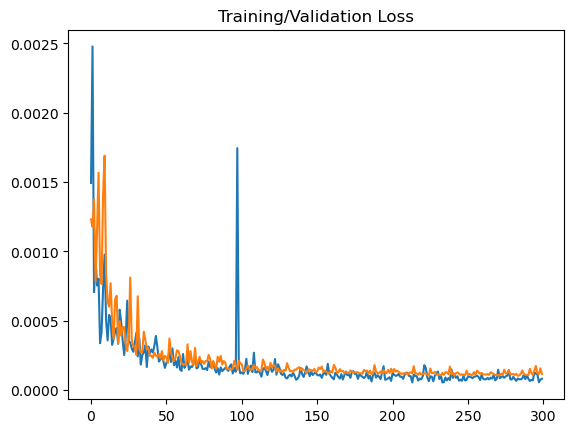

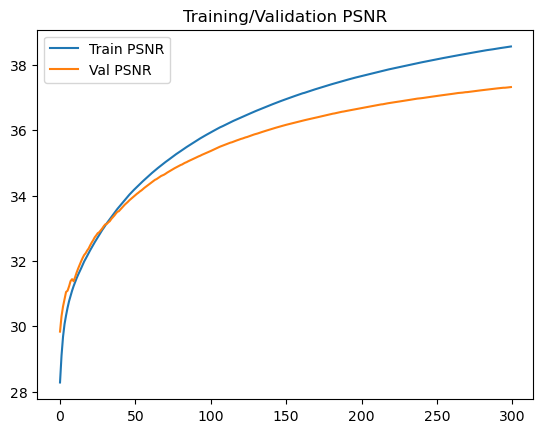

In [20]:
model.to(device)
start=time.time()
outputs, loss_arr, val_loss_arr, psnr, mse, val_psnr, val_mse = train(model, num_epochs=300)# was 300 for MSE
end=time.time()
print('training time = ',end-start)

torch.save(model.state_dict(), 'UNet_base_eusipco_lax.pt')

plt.figure(),plt.plot(np.asarray(loss_arr)),plt.plot(np.asarray(val_loss_arr)),plt.title('Training/Validation Loss')
plt.savefig('train_val_loss_withDropout.png')
plt.figure(),plt.plot(np.asarray(psnr),label='Train PSNR'),plt.plot(np.asarray(val_psnr),label='Val PSNR'),plt.title('Training/Validation PSNR')
plt.legend()
plt.savefig('train_val_PSNR_withDropout.png')
total_params = sum(p.numel() for p in model.parameters())
print(f"Number of parameters: {total_params}")

In [21]:
psnr

array([28.280674, 29.104694, 29.680729, 30.067865, 30.332462, 30.566647,
       30.768229, 30.928913, 31.088963, 31.22665 , 31.349873, 31.469679,
       31.57724 , 31.672342, 31.774258, 31.87825 , 31.98221 , 32.06569 ,
       32.15224 , 32.242912, 32.328213, 32.410683, 32.488884, 32.569923,
       32.646404, 32.7196  , 32.796535, 32.878166, 32.946823, 33.012897,
       33.085217, 33.15219 , 33.21538 , 33.277073, 33.3422  , 33.405056,
       33.46848 , 33.529053, 33.58926 , 33.644714, 33.701294, 33.75982 ,
       33.81571 , 33.870556, 33.923943, 33.975746, 34.028484, 34.078087,
       34.123894, 34.17393 , 34.21918 , 34.26622 , 34.311214, 34.35565 ,
       34.400494, 34.442234, 34.484734, 34.52875 , 34.57115 , 34.613693,
       34.653374, 34.692955, 34.732597, 34.77208 , 34.810368, 34.847275,
       34.883747, 34.92115 , 34.958454, 34.99483 , 35.028706, 35.060387,
       35.095715, 35.13082 , 35.166668, 35.19932 , 35.233715, 35.267582,
       35.297825, 35.328327, 35.36081 , 35.393406, 

In [22]:
PSNR_train=np.mean(psnr)
print(PSNR_train)

36.27196


In [23]:
val_psnr

array([29.837261, 30.30788 , 30.6075  , 30.836304, 31.049587, 31.089203,
       31.222246, 31.383568, 31.442736, 31.37812 , 31.503325, 31.643503,
       31.766033, 31.878155, 31.988989, 32.09113 , 32.180115, 32.236027,
       32.317787, 32.38203 , 32.476807, 32.561962, 32.6358  , 32.722107,
       32.78178 , 32.848648, 32.87821 , 32.935837, 32.993607, 33.06255 ,
       33.118298, 33.132893, 33.17853 , 33.21614 , 33.28326 , 33.33288 ,
       33.38649 , 33.447384, 33.501633, 33.521942, 33.57242 , 33.618984,
       33.67343 , 33.72477 , 33.76627 , 33.808174, 33.856567, 33.896206,
       33.93228 , 33.971733, 34.015587, 34.05445 , 34.088295, 34.12824 ,
       34.158493, 34.19862 , 34.238285, 34.272915, 34.308495, 34.34193 ,
       34.374096, 34.410904, 34.44597 , 34.48258 , 34.50382 , 34.53404 ,
       34.56408 , 34.59821 , 34.618793, 34.640156, 34.66845 , 34.700874,
       34.728607, 34.76003 , 34.783882, 34.809326, 34.837666, 34.8611  ,
       34.882954, 34.91079 , 34.935722, 34.95297 , 

In [24]:
PSNR_val=np.mean(val_psnr)
print(PSNR_val)

35.600082


In [25]:
def eval_model(model, test_loader):
    model.eval()
    psnr= []
    mse= []
    SSIM_arr=[]
    with torch.no_grad():
        j=0
        SSIM=[]
        for noisy_images, targets in test_loader:
            targets= targets.to(device)
            noisy_images= noisy_images.to(device)
            preds=model(noisy_images)
            predictions=preds.cpu().detach().numpy()
            ln=len(predictions)
            print('len_predictions=',ln)
            print('predictions_shape', np.shape((np.moveaxis(predictions,1,-1))))
            for l in range(0,ln):
                p=(np.moveaxis(predictions[l],1,-1))
                p=np.expand_dims(p,axis=-1)
                p=np.concatenate((p,p,p),axis=-1)
                p=np.squeeze(p,axis=0)
                p=(p-np.min(p))/(np.max(p)-np.min(p))
                print('np.max(p)=',np.max(p))
                print('np_shape(p)',np.shape(p))
                p=np.moveaxis(p,0,1)
                print(save_path+str(2*j+l)+'_predict.jpg')
                p=cv2.resize(p,(448,206))
                cv2.imwrite(save_path+str(2*j+l)+'_predict.jpg',p*255)
                # j+=1
            
           
            psnr.extend(PSNR(targets.cpu().detach(), preds.cpu().detach()))
            mse.extend(MSE(targets.cpu().detach(),preds.cpu().detach()))
            j+=1

            t=targets.cpu().detach().numpy()
            pr=preds.cpu().detach().numpy()
            t=np.squeeze(t,axis=1)
            pr=np.squeeze(pr,axis=1)
            for l in range(0,ln):
                s=ssim(t[l,:,:], pr[l,:,:])
                SSIM.append(s)
            # j+=1
        SSIM_arr.append(SSIM)
        print(f"PSNR: Mean: {np.array(psnr).mean()} || Std: {np.array(psnr).std()}")
        print(f"MSE: Mean: {np.array(mse).mean()} || Std: {np.array(mse).std()}")

        return np.array(psnr).mean(), np.array(mse).mean(), SSIM_arr, predictions

In [26]:
##predictions
recon_model= build_base()
state_dict= torch.load('UNet_base_eusipco_lax.pt')
recon_model.load_state_dict(state_dict)
normal_ae_mse= recon_model.to(device)
psnr=[]
with torch.no_grad():
    for i, (images, targets) in enumerate(test_loader):
        noisy_images= images
        noisy_images=noisy_images.to(device)
        targets=targets.to(device)
        preds=recon_model(noisy_images)
        #
        
        if (i<30):#??
            print(PSNR(targets.cpu().detach(),preds.cpu().detach()))
        psnr.extend(PSNR(targets.cpu().detach(), preds.cpu().detach()))

psnr, mse, SSIM_arr, preds= eval_model(model, test_loader)
ss=np.mean(SSIM_arr)
print("SSIM value: ",ss)


tensor([39.9220, 39.8280])
tensor([37.3892, 40.4728])
tensor([37.2834, 41.0730])
tensor([39.8394, 39.3894])
tensor([38.0617, 41.3806])
tensor([39.2104, 40.4092])
tensor([38.6963, 39.7669])
tensor([35.6417, 33.8858])
tensor([37.8629, 40.0166])
tensor([39.9546, 41.2115])
tensor([38.2717, 41.2037])
tensor([38.8550, 39.5864])
tensor([39.0097, 39.7932])
tensor([39.5448, 38.3942])
tensor([23.1524, 40.1070])
tensor([39.1030, 39.5654])
tensor([39.7466, 41.5521])
tensor([37.9447, 40.2400])
tensor([40.6767, 43.0965])
tensor([40.5293, 37.9589])
tensor([41.9798, 38.1142])
tensor([43.1467, 41.4984])
tensor([39.6598, 39.4217])
tensor([39.2288, 31.3453])
tensor([31.8231, 39.3456])
tensor([38.3815, 38.1140])
tensor([43.2382, 42.4349])
tensor([37.5264, 38.8514])
tensor([39.0259, 39.3758])
tensor([37.1549, 40.5396])
len_predictions= 2
predictions_shape (2, 256, 256, 1)
np.max(p)= 1.0
np_shape(p) (256, 256, 3)
C:/Users/ah_wo/Attention_experiments/New_results/Baseline/0_predict.jpg
np.max(p)= 1.0
np_shape

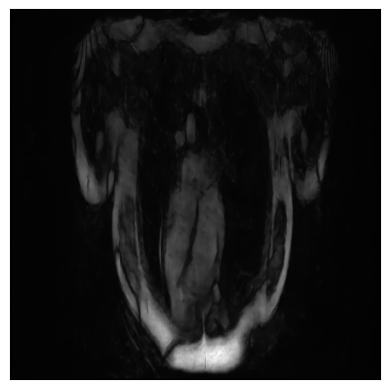

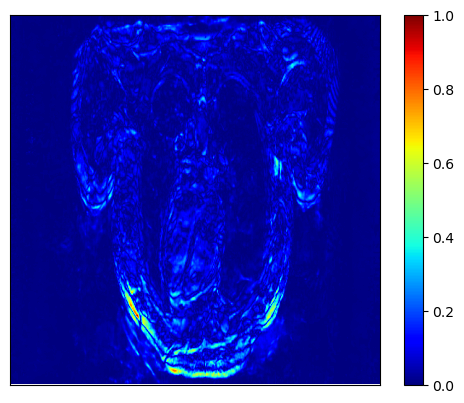

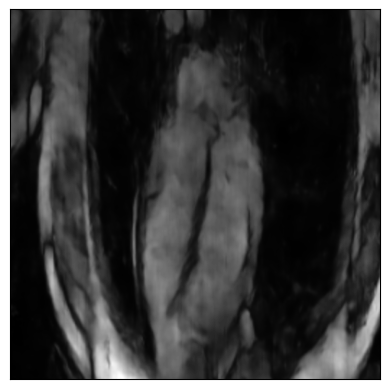

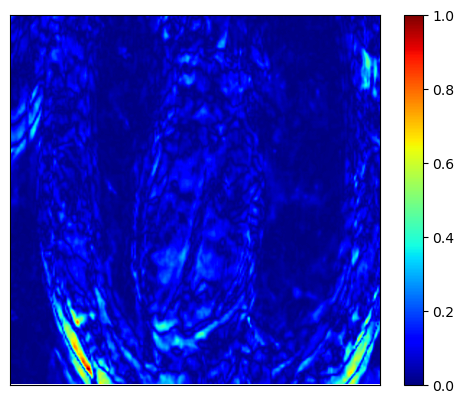

In [29]:


normal_ae_mse = build_base()
state_dict = torch.load("UNet_base_eusipco_lax.pt")
normal_ae_mse.load_state_dict(state_dict)

normal_ae_mse = normal_ae_mse.to(device)

src_dir_GT_LAX='C:\\Users\\ah_wo\\Attention_experiments\\single_coil_train_val\\val_lax_renamed_ALL\\target_FS\\1.png'
#src_dir_GT_SAX='/home/daa/Desktop/CMRxRecon_challenge_MICCAI23/SingleCoil/Cine/Training_Set_julia/train_sax_ALL/target_FS/FS_P002_sax_2_1.jpg'

src_dir_Acc_LAX='C:\\Users\\ah_wo\\Attention_experiments\\single_coil_train_val\\val_lax_renamed_ALL\\input_AC\\1.png'
#src_dir_Acc_SAX='/home/daa/Desktop/CMRxRecon_challenge_MICCAI23/SingleCoil/Cine/Training_Set_julia/train_sax_ALL/input_AC/AC_P002_sax_2_1.jpg'


def read_image(path):
    img = cv2.imread(path)
    img = np.asarray(img, dtype="uint8")
    img = cv2.resize(img, (512, 512))#img = cv2.resize(img, (528, 416) )
    #img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = (img-np.min(img))/(np.max(img)-np.min(img))
    #img=transform(img)
    img=img[:,:,0]
    img=transforms.ToTensor()(img.astype('float32'))
    return img

import torchvision
# do full-resolution first
with torch.no_grad():
            image_name_GT = src_dir_GT_LAX
            image_GT=read_image(image_name_GT)
            image_ACC=read_image(src_dir_Acc_LAX)
            image_ACC=image_ACC.unsqueeze(1)
            noisy_image = image_ACC.to(device)
            
            preds_0 = normal_ae_mse(noisy_image)
            preds_0=preds_0.squeeze(0)
            image_ACC = image_ACC.squeeze(0)
            #image_GT.to(device)
            preds_0=preds_0.to('cpu').numpy()
            image_ACC=image_ACC.to('cpu').numpy()
            image_GT=image_GT.to('cpu').numpy()
            
            image_GT=np.squeeze(image_GT,0)
            preds_0=np.squeeze(preds_0,0)
            
            error_0 = np.abs(image_GT - preds_0)
            #error_0 = zoom_at(error_0, 2, coord=(250, 300))
            error_0=(error_0-np.min(error_0))/(np.max(error_0)-np.min(error_0))
            
plt.figure()
plt.imshow(preds_0, cmap='gray')
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False)
plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=False,      # ticks along the bottom edge are off
    right=False,         # ticks along the top edge are off
    labelleft=False)
plt.savefig('UNet_base_reconstructed_fullres_2.jpg')

plt.figure()
plt.imshow(error_0,cmap='jet')
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False)
plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=False,      # ticks along the bottom edge are off
    right=False,         # ticks along the top edge are off
    labelleft=False)
plt.colorbar()
plt.savefig('UNet_base_reconstructed_fullres_error_2.jpg')


"=============================================================================="
# now do zoom plots
def zoom_at(img, zoom, coord=None):
    """
    Simple image zooming without boundary checking.
    Centered at "coord", if given, else the image center.

    img: numpy.ndarray of shape (h,w,:)
    zoom: float
    coord: (float, float)
    """
    # Translate to zoomed coordinates
    h, w = [ zoom * i for i in img.shape ]
    
    if coord is None: cx, cy = w/2, h/2
    else: cx, cy = [ zoom*c for c in coord ]
    
    img = cv2.resize( img, (0, 0), fx=zoom, fy=zoom)
    img = img[ int(round(cy - h/zoom * .5)) : int(round(cy + h/zoom * .5)),
               int(round(cx - w/zoom * .5)) : int(round(cx + w/zoom * .5))]
    
    return img




with torch.no_grad():
            image_name_GT = src_dir_GT_LAX
            image_GT=read_image(image_name_GT)
            image_ACC=read_image(src_dir_Acc_LAX)
            image_ACC=image_ACC.unsqueeze(1)
            noisy_image = image_ACC.to(device)
            
            preds_0 = normal_ae_mse(noisy_image)
            preds_0=preds_0.squeeze(0)
            image_ACC = image_ACC.squeeze(0)
            #image_GT.to(device)
            preds_0=preds_0.to('cpu').numpy()
            image_ACC=image_ACC.to('cpu').numpy()
            image_GT=image_GT.to('cpu').numpy()
            
            image_GT=np.squeeze(image_GT,0)
            
            preds_0=np.squeeze(preds_0,0)
            
            error_0 =np.abs(image_GT - preds_0)
            error_0 = zoom_at(error_0, 2, coord=(250, 300))
            error_0=(error_0-np.min(error_0))/(np.max(error_0)-np.min(error_0))
            
            preds_0_zoomed=zoom_at(preds_0, 2, coord=(250, 300))
            
plt.figure()
plt.imshow(preds_0_zoomed, cmap='gray')
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False)
plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=False,      # ticks along the bottom edge are off
    right=False,         # ticks along the top edge are off
    labelleft=False)
plt.savefig('UNet_base_reconstructed_zoomed_2.jpg')

plt.figure()
plt.imshow(error_0,cmap='jet'),
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False)
plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=False,      # ticks along the bottom edge are off
    right=False,         # ticks along the top edge are off
    labelleft=False)
plt.colorbar()
plt.savefig('UNet_base_reconstructed_error_zoomed_2.jpg')

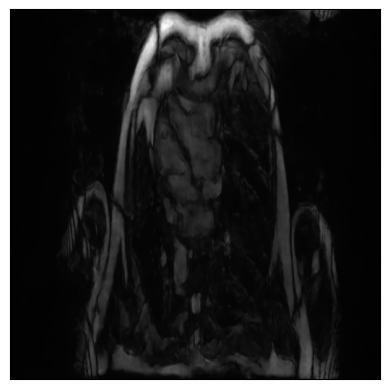

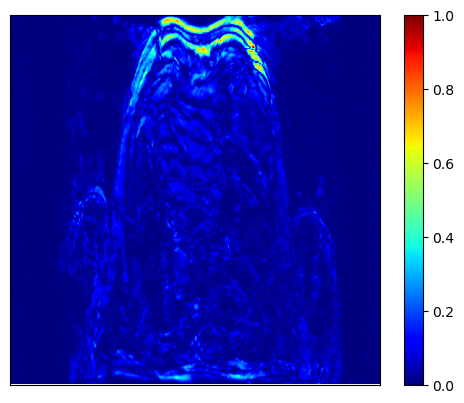

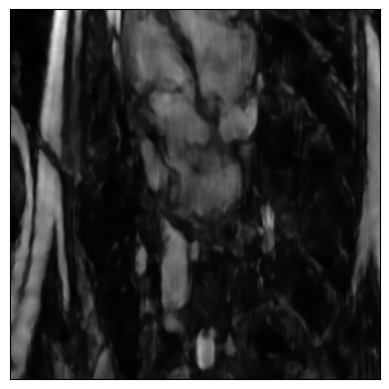

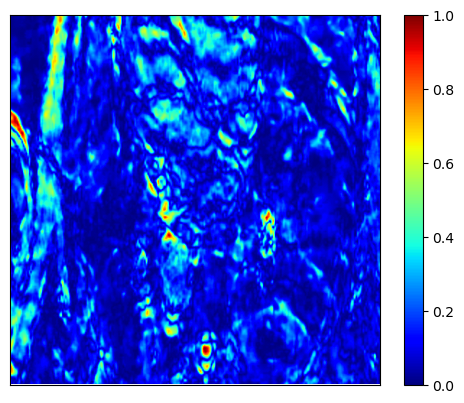

In [33]:


normal_ae_mse = build_base()
state_dict = torch.load("UNet_base_eusipco_lax.pt")
normal_ae_mse.load_state_dict(state_dict)

normal_ae_mse = normal_ae_mse.to(device)

src_dir_GT_LAX='C:\\Users\\ah_wo\\Attention_experiments\\single_coil_train_val\\val_lax_renamed_ALL\\target_FS\\2.png'
#src_dir_GT_SAX='/home/daa/Desktop/CMRxRecon_challenge_MICCAI23/SingleCoil/Cine/Training_Set_julia/train_sax_ALL/target_FS/FS_P002_sax_2_1.jpg'

src_dir_Acc_LAX='C:\\Users\\ah_wo\\Attention_experiments\\single_coil_train_val\\val_lax_renamed_ALL\\input_AC\\2.png'
#src_dir_Acc_SAX='/home/daa/Desktop/CMRxRecon_challenge_MICCAI23/SingleCoil/Cine/Training_Set_julia/train_sax_ALL/input_AC/AC_P002_sax_2_1.jpg'


def read_image(path):
    img = cv2.imread(path)
    img = np.asarray(img, dtype="uint8")
    img = cv2.resize(img, (512, 512))#img = cv2.resize(img, (528, 416) )
    #img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = (img-np.min(img))/(np.max(img)-np.min(img))
    #img=transform(img)
    img=img[:,:,0]
    img=transforms.ToTensor()(img.astype('float32'))
    return img

import torchvision
# do full-resolution first
with torch.no_grad():
            image_name_GT = src_dir_GT_LAX
            image_GT=read_image(image_name_GT)
            image_ACC=read_image(src_dir_Acc_LAX)
            image_ACC=image_ACC.unsqueeze(1)
            noisy_image = image_ACC.to(device)
            
            preds_0 = normal_ae_mse(noisy_image)
            preds_0=preds_0.squeeze(0)
            image_ACC = image_ACC.squeeze(0)
            #image_GT.to(device)
            preds_0=preds_0.to('cpu').numpy()
            image_ACC=image_ACC.to('cpu').numpy()
            image_GT=image_GT.to('cpu').numpy()
            
            image_GT=np.squeeze(image_GT,0)
            preds_0=np.squeeze(preds_0,0)
            
            error_0 = np.abs(image_GT - preds_0)
            #error_0 = zoom_at(error_0, 2, coord=(250, 300))
            error_0=(error_0-np.min(error_0))/(np.max(error_0)-np.min(error_0))
            
plt.figure()
plt.imshow(preds_0, cmap='gray')
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False)
plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=False,      # ticks along the bottom edge are off
    right=False,         # ticks along the top edge are off
    labelleft=False)
# plt.savefig('UNet_base_reconstr2.jpg')

plt.figure()
plt.imshow(error_0,cmap='jet')
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False)
plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=False,      # ticks along the bottom edge are off
    right=False,         # ticks along the top edge are off
    labelleft=False)
plt.colorbar()
# plt.savefig('UNet_base_reconstructed_fullres_error_2.jpg')


"=============================================================================="
# now do zoom plots
def zoom_at(img, zoom, coord=None):
    """
    Simple image zooming without boundary checking.
    Centered at "coord", if given, else the image center.

    img: numpy.ndarray of shape (h,w,:)
    zoom: float
    coord: (float, float)
    """
    # Translate to zoomed coordinates
    h, w = [ zoom * i for i in img.shape ]
    
    if coord is None: cx, cy = w/2, h/2
    else: cx, cy = [ zoom*c for c in coord ]
    
    img = cv2.resize( img, (0, 0), fx=zoom, fy=zoom)
    img = img[ int(round(cy - h/zoom * .5)) : int(round(cy + h/zoom * .5)),
               int(round(cx - w/zoom * .5)) : int(round(cx + w/zoom * .5))]
    
    return img




with torch.no_grad():
            image_name_GT = src_dir_GT_LAX
            image_GT=read_image(image_name_GT)
            image_ACC=read_image(src_dir_Acc_LAX)
            image_ACC=image_ACC.unsqueeze(1)
            noisy_image = image_ACC.to(device)
            
            preds_0 = normal_ae_mse(noisy_image)
            preds_0=preds_0.squeeze(0)
            image_ACC = image_ACC.squeeze(0)
            #image_GT.to(device)
            preds_0=preds_0.to('cpu').numpy()
            image_ACC=image_ACC.to('cpu').numpy()
            image_GT=image_GT.to('cpu').numpy()
            
            image_GT=np.squeeze(image_GT,0)
            
            preds_0=np.squeeze(preds_0,0)
            
            error_0 =np.abs(image_GT - preds_0)
            error_0 = zoom_at(error_0, 2, coord=(250, 300))
            error_0=(error_0-np.min(error_0))/(np.max(error_0)-np.min(error_0))
            
            preds_0_zoomed=zoom_at(preds_0, 2, coord=(250, 300))
            
plt.figure()
plt.imshow(preds_0_zoomed, cmap='gray')
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False)
plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=False,      # ticks along the bottom edge are off
    right=False,         # ticks along the top edge are off
    labelleft=False)
# plt.savefig('UNet_base_reconstructed_zoomed_2.jpg')

plt.figure()
plt.imshow(error_0,cmap='jet'),
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False)
plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=False,      # ticks along the bottom edge are off
    right=False,         # ticks along the top edge are off
    labelleft=False)
plt.colorbar()
# plt.savefig('UNet_base_reconstructed_error_zoomed_2.jpg')

In [49]:
import os
import random


import random

def generate_random_numbers(n, start_range, end_range):
    return [random.randint(start_range, end_range) for _ in range(n)]

# Example: Generate 5 random numbers between 1 and 100
random_numbers = generate_random_numbers(5, 0, 200)

print("Random Numbers:", random_numbers)


src_dir_GT_LAX = 'C:\\Users\\ah_wo\\Attention_experiments\\single_coil_train_val\\val_lax_renamed_ALL\\target_FS\\'
src_dir_Acc_LAX='C:\\Users\\ah_wo\\Attention_experiments\\single_coil_train_val\\val_lax_renamed_ALL\\input_AC\\'
# Get a list of all files in the directory
all_files = os.listdir(src_dir_GT_LAX)
all_files_1 = os.listdir(src_dir_Acc_LAX)

# Filter out only image files (you might need to adjust this depending on your file naming conventions)
image_files = [file for file in all_files if file.lower().endswith(('.png', '.jpg', '.jpeg'))]
image_files_1 = [file for file in all_files_1 if file.lower().endswith(('.png', '.jpg', '.jpeg'))]

# Randomly select one image
def read_image(path):
    img = cv2.imread(path)
    img = np.asarray(img, dtype="uint8")
    img = cv2.resize(img, (512, 512))#img = cv2.resize(img, (528, 416) )
    #img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = (img-np.min(img))/(np.max(img)-np.min(img))
    #img=transform(img)
    img=img[:,:,0]
    img=transforms.ToTensor()(img.astype('float32'))
    return img

import torchvision

# Construct the full path to the selected image
for i in random_numbers:
       selected_image = image_files[i]
       selected_image_1 = image_files_1[i]
       selected_image_path = os.path.join(src_dir_GT_LAX, selected_image )
       print(f"Selected Image: {selected_image_path}")
       selected_image_path_1 = os.path.join(src_dir_Acc_LAX, selected_image_1)
       print(f"Selected Image: {selected_image_path_1}")
       with torch.no_grad():
            image_name_GT = src_dir_GT_LAX
            image_GT=read_image(image_name_GT)
            image_ACC=read_image(src_dir_Acc_LAX)
            image_ACC=image_ACC.unsqueeze(1)
            noisy_image = image_ACC.to(device)
            
            preds_0 = normal_ae_mse(noisy_image)
            preds_0=preds_0.squeeze(0)
            image_ACC = image_ACC.squeeze(0)
            #image_GT.to(device)
            preds_0=preds_0.to('cpu').numpy()
            image_ACC=image_ACC.to('cpu').numpy()
            image_GT=image_GT.to('cpu').numpy()
            
            image_GT=np.squeeze(image_GT,0)
            preds_0=np.squeeze(preds_0,0)
            
            error_0 = np.abs(image_GT - preds_0)
            #error_0 = zoom_at(error_0, 2, coord=(250, 300))
            error_0=(error_0-np.min(error_0))/(np.max(error_0)-np.min(error_0))
        plt.figure()
        plt.imshow(preds_0, cmap='gray')
        plt.tick_params(axis='x',  which='both',bottom=False, top=False,labelbottom=False)        
   
    
        plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=False,      # ticks along the bottom edge are off
    right=False,         # ticks along the top edge are off
    labelleft=False)
# plt.savefig('UNet_base_reconstr2.jpg')

        plt.figure()
        plt.imshow(error_0,cmap='jet')
        plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False)
        plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=False,      # ticks along the bottom edge are off
    right=False,         # ticks along the top edge are off
    labelleft=False)
    plt.colorbar()
# plt.savefig('UNet_base_reconstructed_fullres_error_2.jpg')
            



IndentationError: unindent does not match any outer indentation level (<tokenize>, line 69)